#**Load Dataset**
*American Epilepsy Society Seizure Prediction Challenge Patient 1*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
#Conts
PATIENT_DATASET = "/content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1"

In [ ]:
import os
import numpy as np
from scipy.io import loadmat

def load_patient_data(patient_dir):
    windows = []
    for fname in os.listdir(patient_dir):
        if not fname.endswith('.mat') or 'test' in fname.lower():
            continue
        full = os.path.join(patient_dir, fname)
        mat = loadmat(full, struct_as_record=False, squeeze_me=True)
        # grab the single struct variable (non-__meta__ key)
        key = next(k for k in mat if not k.startswith('__'))
        s = mat[key]

        eeg = np.array(s.data, dtype=float)               # (n_channels, n_samples)
        fs  = float(s.sampling_frequency)                 # e.g. 5000
        label = 1 if 'preictal' in fname.lower() else 0   # decide by filename

        windows.append((eeg, fs, label))

    return windows

In [ ]:
windows = load_patient_data(PATIENT_DATASET)
print(f"Loaded {len(windows)} windows:")
print("  Inter‑ictal:", sum(1 for _,_,lbl in windows if lbl==0))
print("  Pre-ictal:", sum(1 for _,_,lbl in windows if lbl==1))

Loaded 68 windows:
  Inter‑ictal: 50
  Pre-ictal: 18


Variable name in MAT file: interictal_segment_1
Fields available in struct: ['data', 'data_length_sec', 'sampling_frequency', 'channels', 'sequence']
  data           → <class 'numpy.ndarray'> shape: (15, 3000000)
  data_length_sec→ 600
  sampling_freq  → 5000
  channels       → ['LD_1' 'LD_3' 'LD_4' 'LD_5' 'LD_6' 'LD_7' 'LD_8' 'RD_1' 'RD_2' 'RD_3'
 'RD_4' 'RD_5' 'RD_6' 'RD_7' 'RD_8']
  sequence       → 1

Extracted EEG matrix of shape (15, 3000000), sampled at 5000.0 Hz


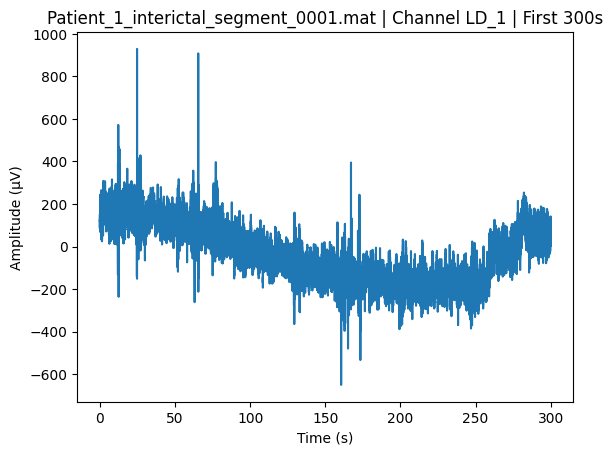

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1) Path to your file
mat_file = '/content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_interictal_segment_0001.mat'

# 2) Load the .mat, letting scipy unpack structs into Python objects
mat = loadmat(mat_file,
              struct_as_record=False,  # so MATLAB structs become Python objects
              squeeze_me=True)         # so 1×1 arrays become scalars

# 3) Find the one “real” variable (ignore __header__, __version__, __globals__)
varname = next(k for k in mat.keys() if not k.startswith('__'))
print("Variable name in MAT file:", varname)

# 4) Grab that struct
s = mat[varname]

# 5) Inspect its fields (attributes)
print("Fields available in struct:", s._fieldnames)  # e.g. ['data','data_length_sec',...]

# 6) Look at each field’s type and shape/value
print("  data           →", type(s.data), "shape:", np.shape(s.data))
print("  data_length_sec→", s.data_length_sec)       # e.g. 600.0 seconds
print("  sampling_freq  →", s.sampling_frequency)    # e.g. 5000.0 Hz
print("  channels       →", s.channels)              # list of channel labels
print("  sequence       →", s.sequence)              # trial/segment index

# 7) Extract the EEG array and sampling rate
eeg = np.array(s.data, dtype=float)                  # shape (n_channels, n_samples)
fs  = float(s.sampling_frequency)

print(f"\nExtracted EEG matrix of shape {eeg.shape}, sampled at {fs} Hz")
# 8) Choose a single channel (e.g. channel 0) and a short duration (e.g. 2 s)
channel_idx   = 0
duration_sec  = 300
nsamples_plot = int(duration_sec * fs)
signal        = eeg[channel_idx, :nsamples_plot]

# 9) Build a time axis in seconds and plot
t = np.arange(nsamples_plot) / fs
plt.figure()
plt.plot(t, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.title(f"{os.path.basename(mat_file)} | Channel {s.channels[channel_idx]} | First {duration_sec}s")
plt.show()

# Setting the Hyperparameters


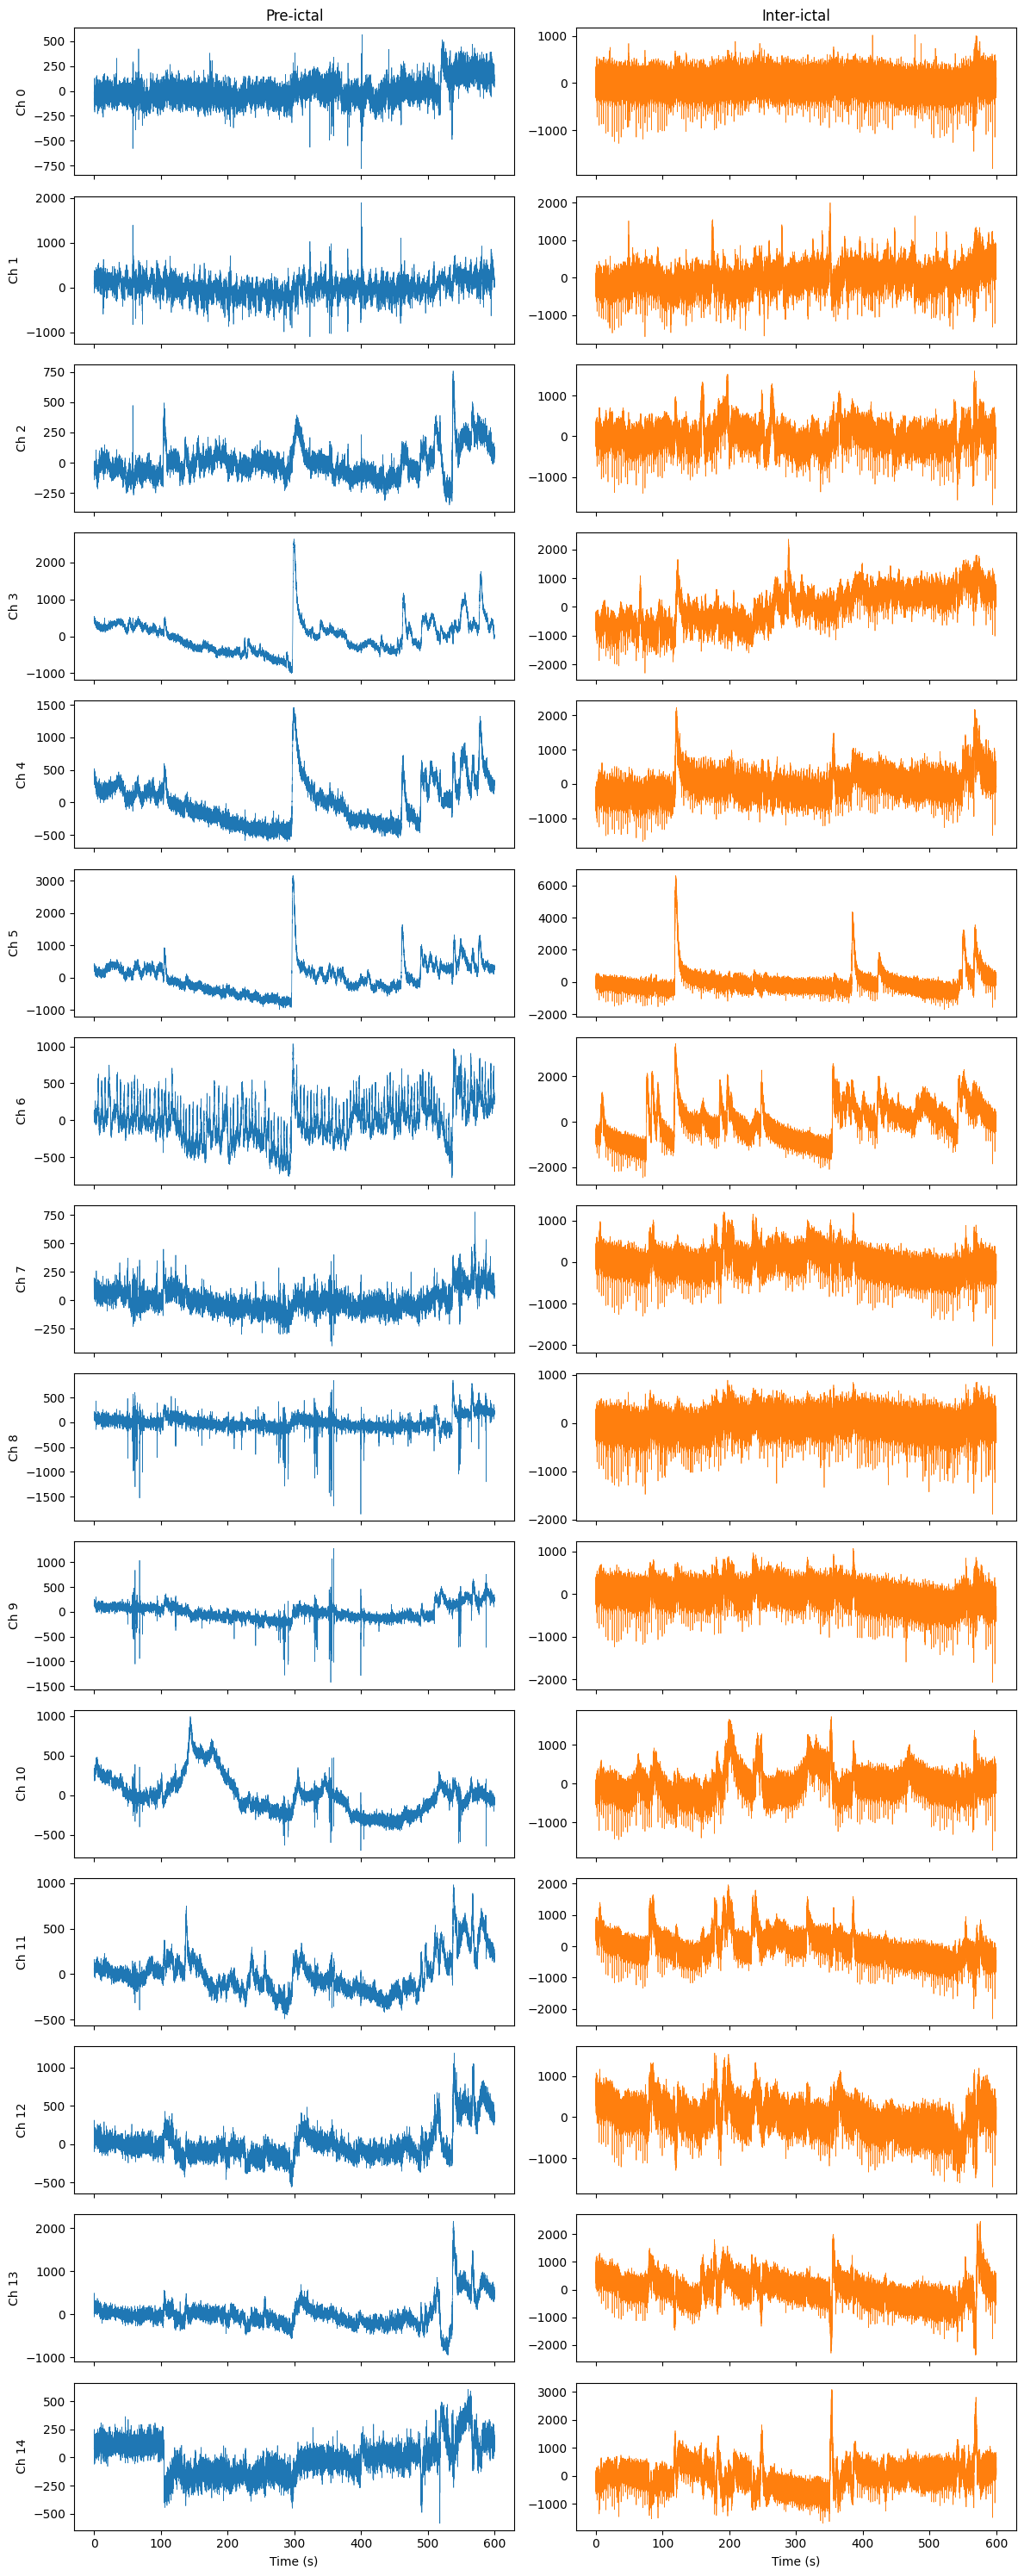

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── SETTINGS ────────────────────────────────────────────────────────────────
target_fs   = 500   # down-sample to 500 Hz
pre_fn  = "Patient_1_preictal_segment_0017.mat"
int_fn  = "Patient_1_interictal_segment_0017.mat"

def load_segment(fn):
    data = loadmat(f"{PATIENT_DATASET}/{fn}", struct_as_record=False, squeeze_me=True)
    key  = next(k for k in data if not k.startswith("__"))
    s    = data[key]
    sig  = s.data      # shape (n_ch, n_samps)
    fs   = float(s.sampling_frequency)
    # down‑sample each channel
    factor = int(round(fs/target_fs))
    return decimate(sig, factor, axis=1, zero_phase=True), target_fs

# load & down‑sample
pre_sig,  fs_ds = load_segment(pre_fn)
int_sig,  fs_ds = load_segment(int_fn)
n_ch, n_samps  = pre_sig.shape
t = np.arange(n_samps)/fs_ds  # seconds

# ─── PLOT ───────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(n_ch, 2, figsize=(12, 2*n_ch), sharex=True)
for ch in range(n_ch):
    axes[ch,0].plot(t, pre_sig[ch], lw=0.5)
    axes[ch,0].set_ylabel(f"Ch {ch}")
    if ch==0: axes[ch,0].set_title("Pre‑ictal")
    axes[ch,1].plot(t, int_sig[ch], lw=0.5, color='C1')
    if ch==0: axes[ch,1].set_title("Inter‑ictal")

axes[-1,0].set_xlabel("Time (s)")
axes[-1,1].set_xlabel("Time (s)")
fig.tight_layout()
plt.show()


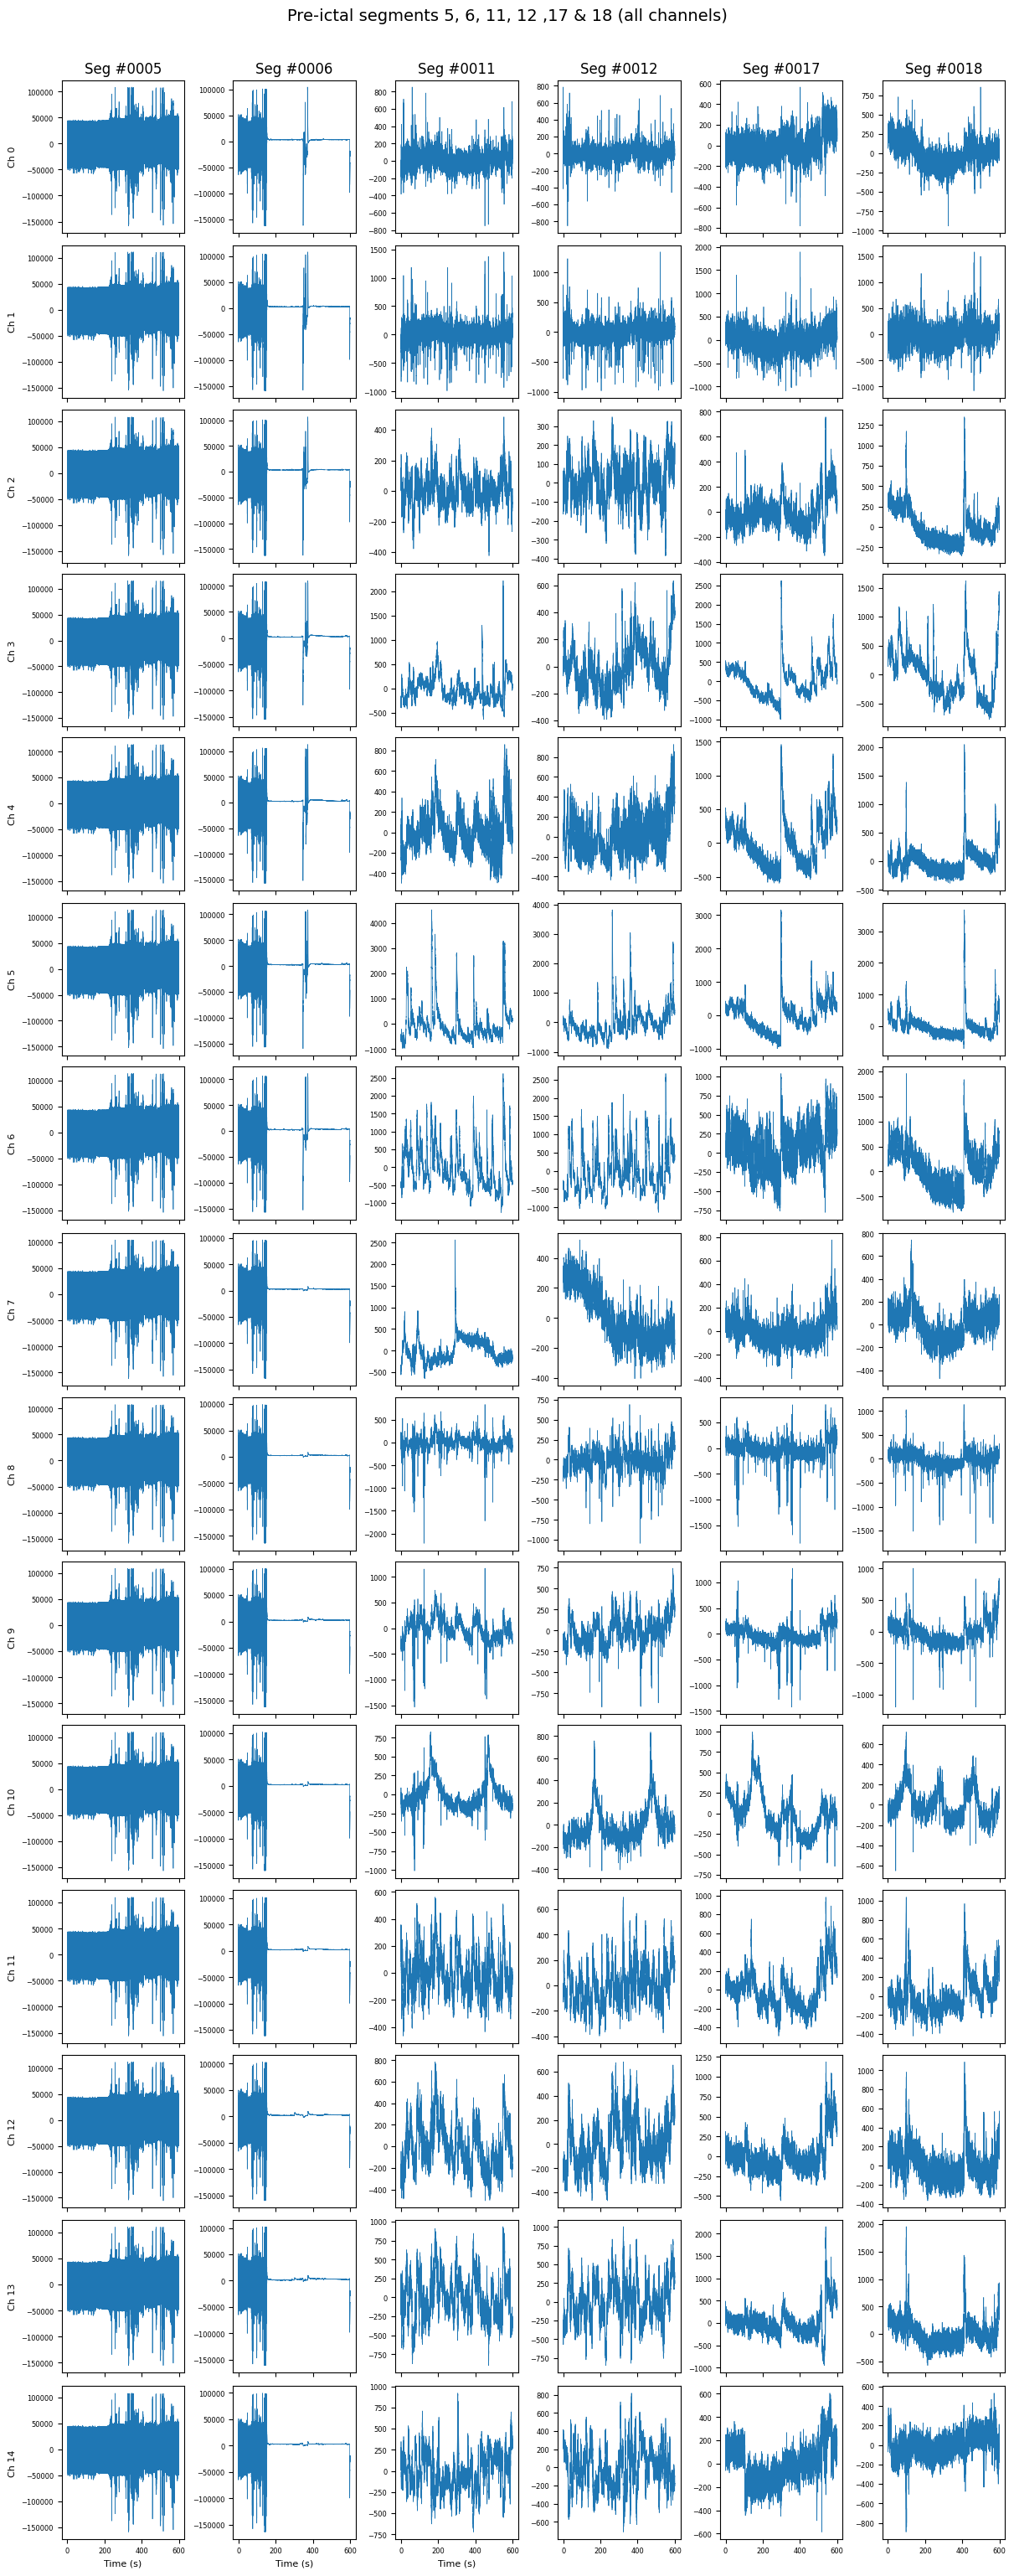

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── SETTINGS ─────────────────────────────────────────────────────────────────
target_fs   = 500   # Hz after down‑sampling

# the three “sequence‑6” files for each of the 3 seizures:
seqs = ["0005","0006","0011", "0012","0017", "0018"]
files = []
for seq in seqs:
    fn = f"Patient_1_preictal_segment_{seq}.mat"
    path = os.path.join(PATIENT_DATASET, fn)
    if os.path.exists(path):
        files.append(path)
    else:
        raise FileNotFoundError(f"Expected {fn} in {PATIENT_DATASET}")

# ─── LOAD & DOWNSAMPLE ALL THREE ──────────────────────────────────────────────
data_ds = []
for path in files:
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    key = next(k for k in mat if not k.startswith("__"))
    s   = mat[key]
    eeg = s.data            # shape (n_ch, n_samps)
    fs  = float(s.sampling_frequency)

    factor = int(round(fs/target_fs))
    dsig   = decimate(eeg, factor, axis=1, zero_phase=True)
    data_ds.append(dsig)

# ─── PLOT GRID ────────────────────────────────────────────────────────────────
n_ch, n_samps = data_ds[0].shape
t = np.arange(n_samps) / target_fs

fig, axes = plt.subplots(n_ch, 6, figsize=(12, 2*n_ch), sharex=True, constrained_layout=True)
for col, dsig in enumerate(data_ds):
    for ch in range(n_ch):
        ax = axes[ch, col]
        ax.plot(t, dsig[ch], lw=0.5)
        if ch == 0:
            ax.set_title(f"Seg #{seqs[col]}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"Ch {ch}", fontsize=8)
        ax.tick_params(labelsize=6)

# common labels
axes[-1,0].set_xlabel("Time (s)", fontsize=8)
axes[-1,1].set_xlabel("Time (s)", fontsize=8)
axes[-1,2].set_xlabel("Time (s)", fontsize=8)
fig.suptitle("Pre‑ictal segments 5, 6, 11, 12 ,17 & 18 (all channels)", fontsize=14, y=1.02)
plt.show()


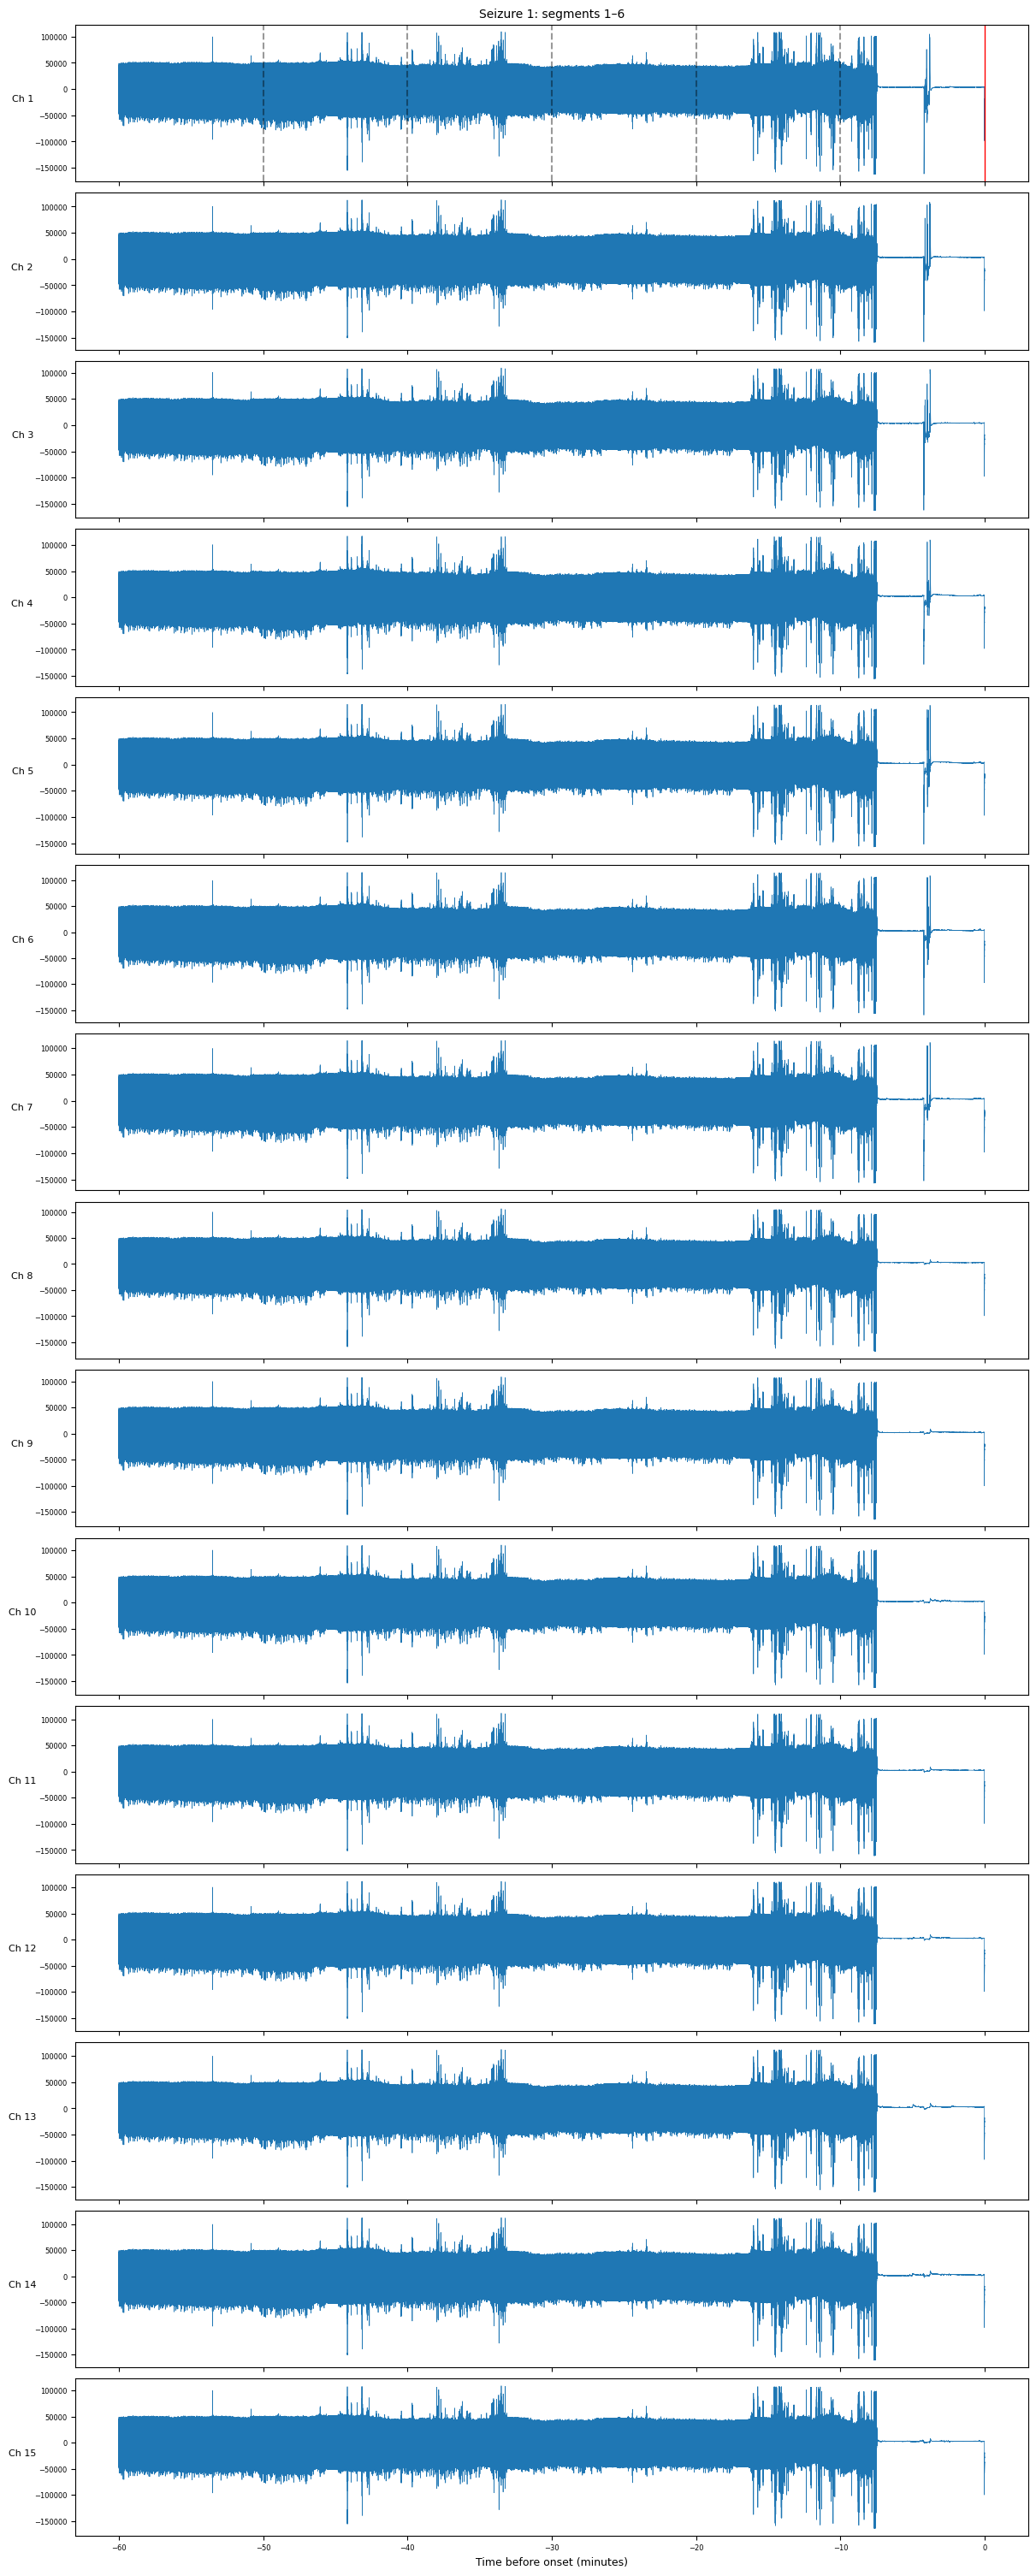

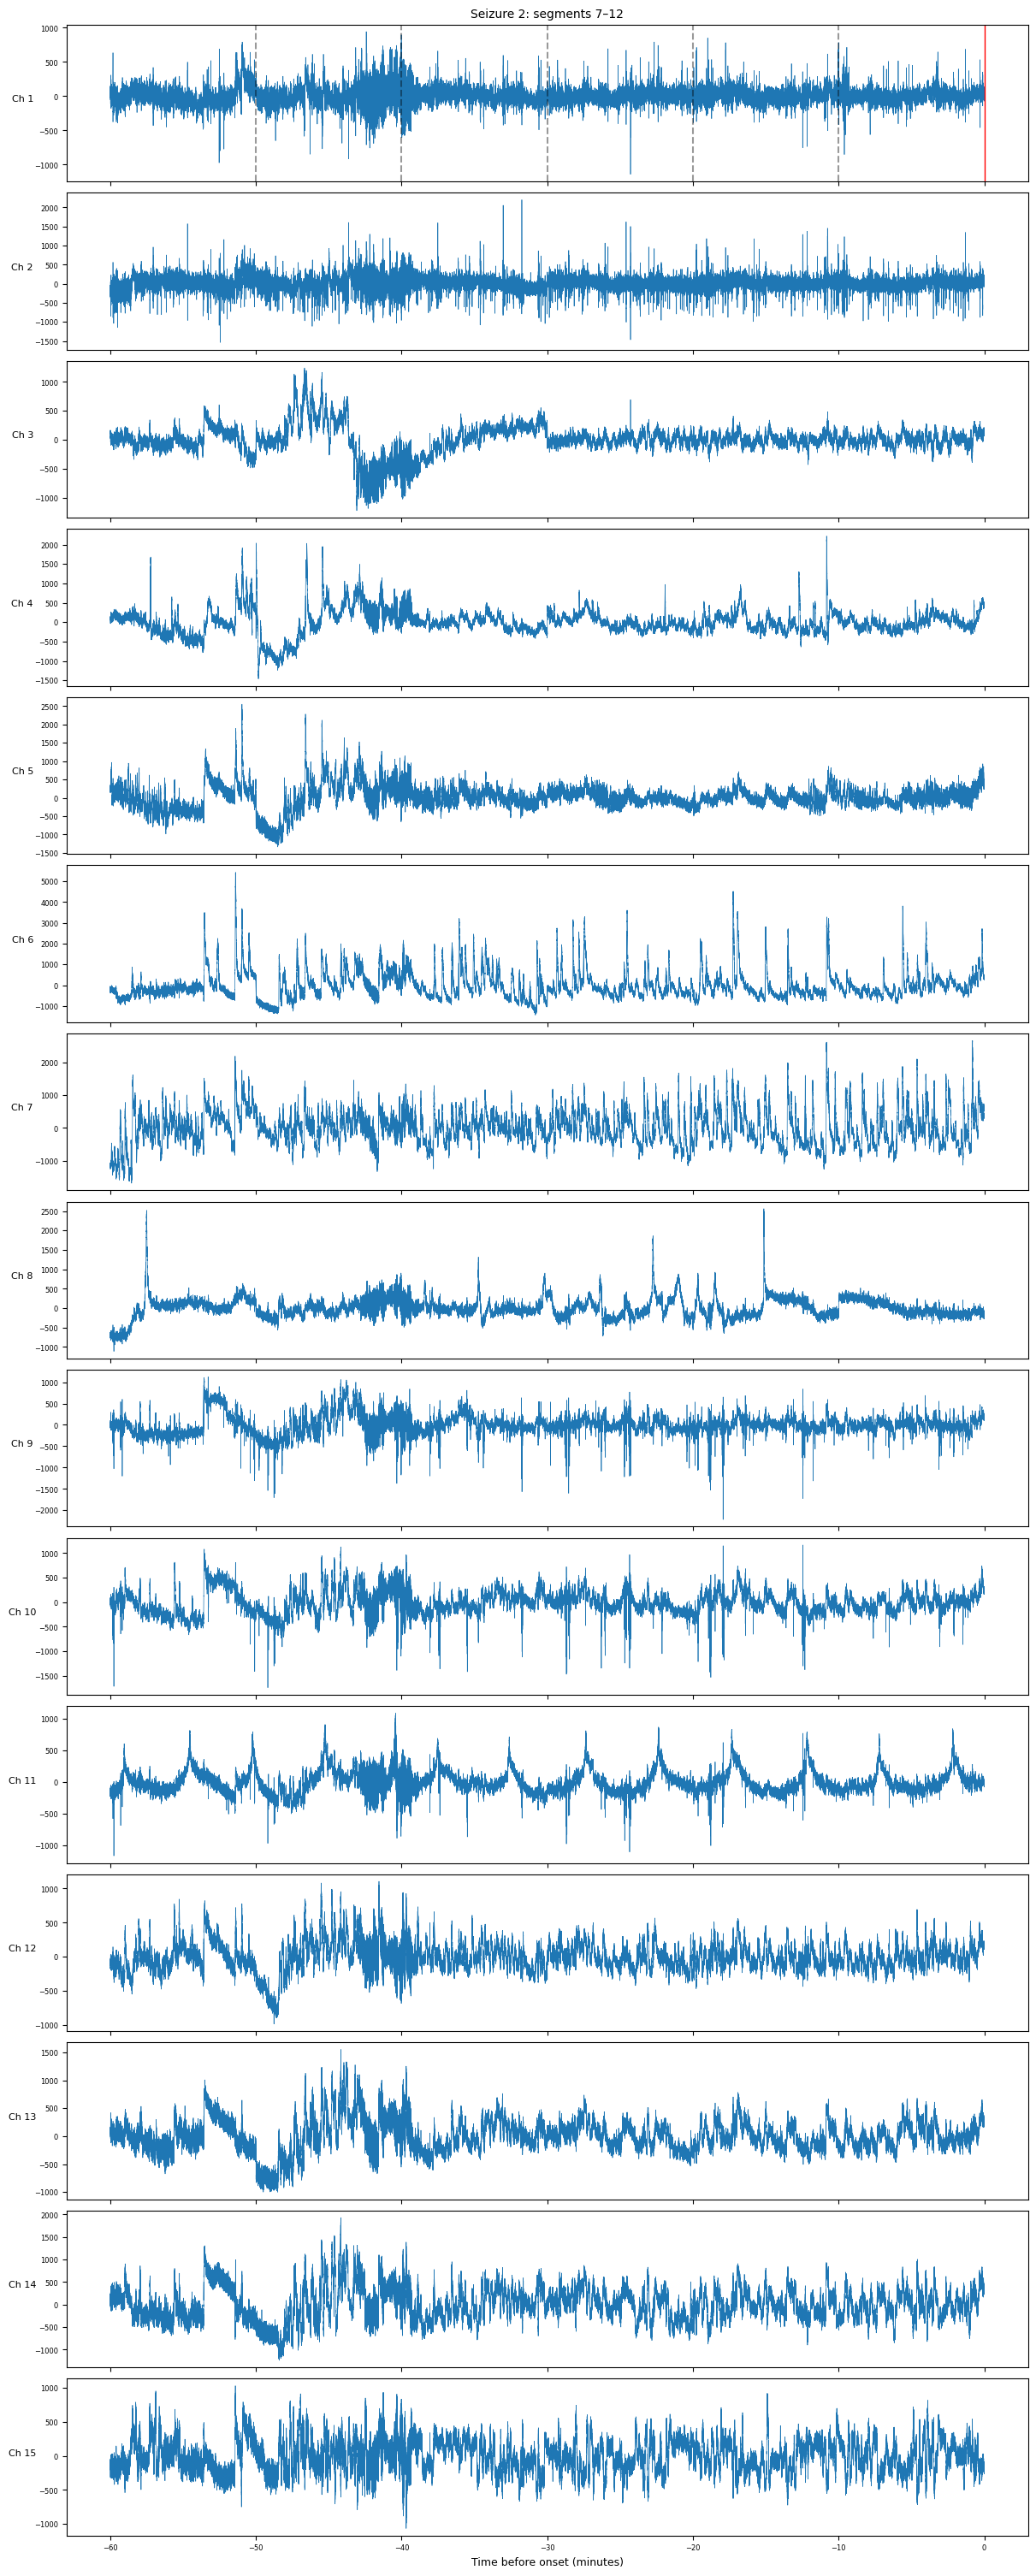

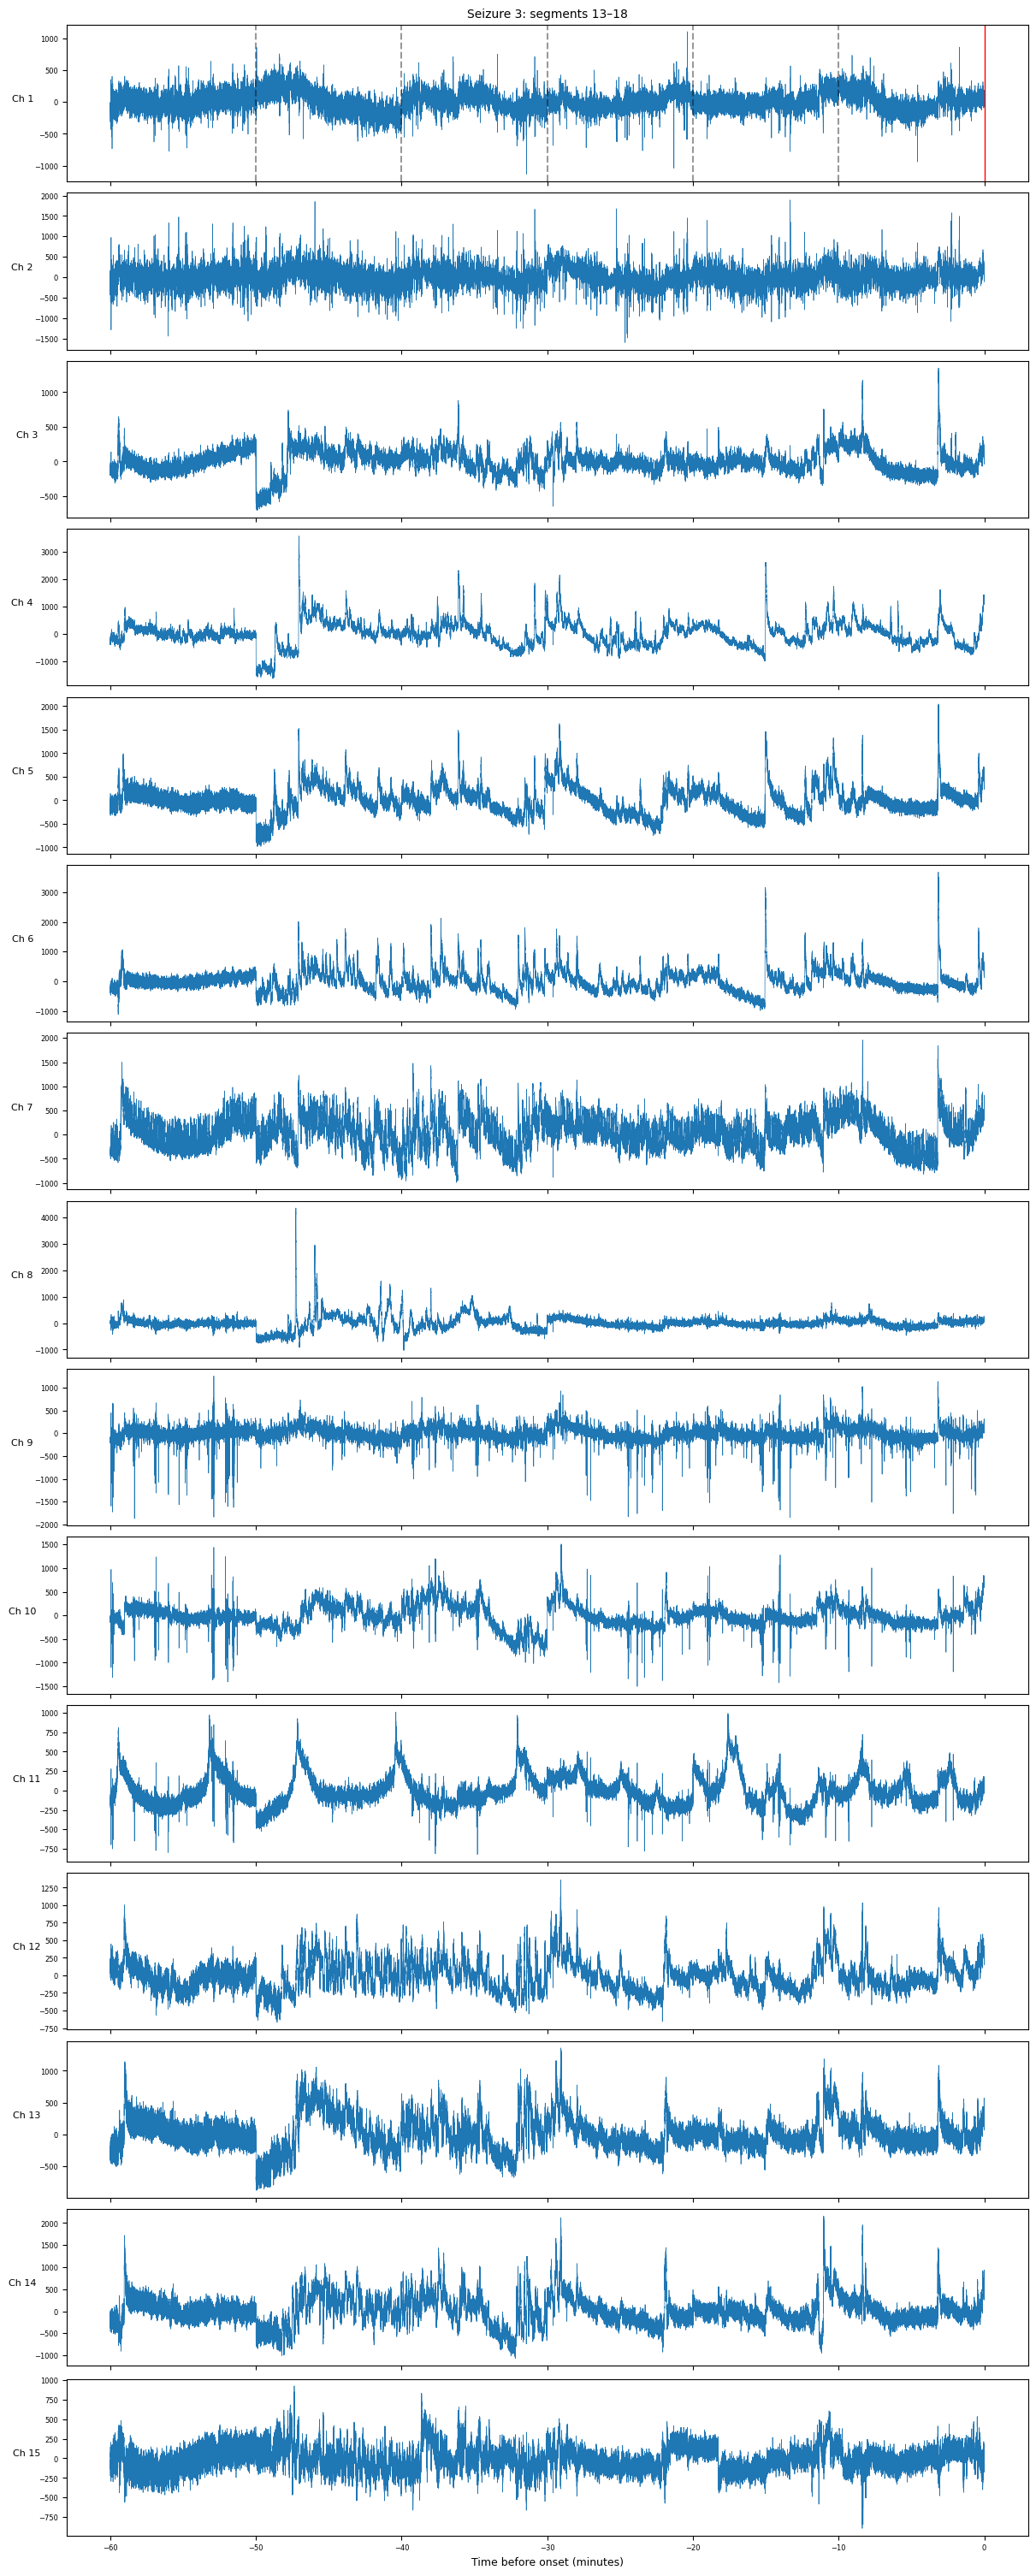

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import decimate

# ─── CONFIG ──────────────────────────────────────────────────────────────────
target_fs   = 500     # Hz down‑sample rate
WS_min      = 10      # each segment is 10 min long
n_channels  = 15      # number of electrodes

# helper to load & downsample one .mat
def load_ds_segment(fn):
    m = loadmat(fn, struct_as_record=False, squeeze_me=True)
    key = next(k for k in m if not k.startswith("__"))
    s   = m[key]
    eeg = s.data                   # shape (15, orig_samps)
    fs  = float(s.sampling_frequency)
    factor = int(round(fs/target_fs))
    return decimate(eeg, factor, axis=1, zero_phase=True)

# the three seizure‐groups: segments 1–6, 7–12, 13–18
groups = [
    list(range(1,  7)),   # seq 1→6 = seizure 1
    list(range(7, 13)),   # seq 7→12 = seizure 2
    list(range(13,19)),   # seq 13→18 = seizure 3
]

for gi, seg_nums in enumerate(groups, start=1):
    # 1) load & ds each of the 6 segments for this group
    clips = []
    for seg in seg_nums:
        fn = f"Patient_1_preictal_segment_{seg:04d}.mat"
        path = os.path.join(PATIENT_DATASET, fn)
        clips.append(load_ds_segment(path))
    # 2) concatenate along time
    full = np.concatenate(clips, axis=1)  # shape (15, n_samps_total)
    n_samps = full.shape[1]
    # 3) build time axis in minutes before seizure onset
    total_min = WS_min * len(seg_nums)
    t = np.linspace(-total_min, 0, n_samps)  # from -60…0 min for group 1, etc.

    # 4) plot all channels stacked
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 2*n_channels),
                             sharex=True, constrained_layout=True)
    for ch in range(n_channels):
        axes[ch].plot(t, full[ch], lw=0.5)
        axes[ch].set_ylabel(f"Ch {ch+1}", rotation=0, labelpad=10, fontsize=8)
        axes[ch].tick_params(labelsize=6)
        if ch == 0:
            axes[ch].set_title(f"Seizure {gi}: segments {seg_nums[0]}–{seg_nums[-1]}", fontsize=10)
    axes[-1].set_xlabel("Time before onset (minutes)", fontsize=9)

    # mark segment boundaries every 10 min
    for k in range(1, len(seg_nums)):
        axes[0].axvline(-total_min + k*WS_min, color='k', linestyle='--', alpha=0.4)
    # mark seizure onset at t=0
    axes[0].axvline(0, color='r', linestyle='-', lw=1)

    plt.show()


In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 127.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 124.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

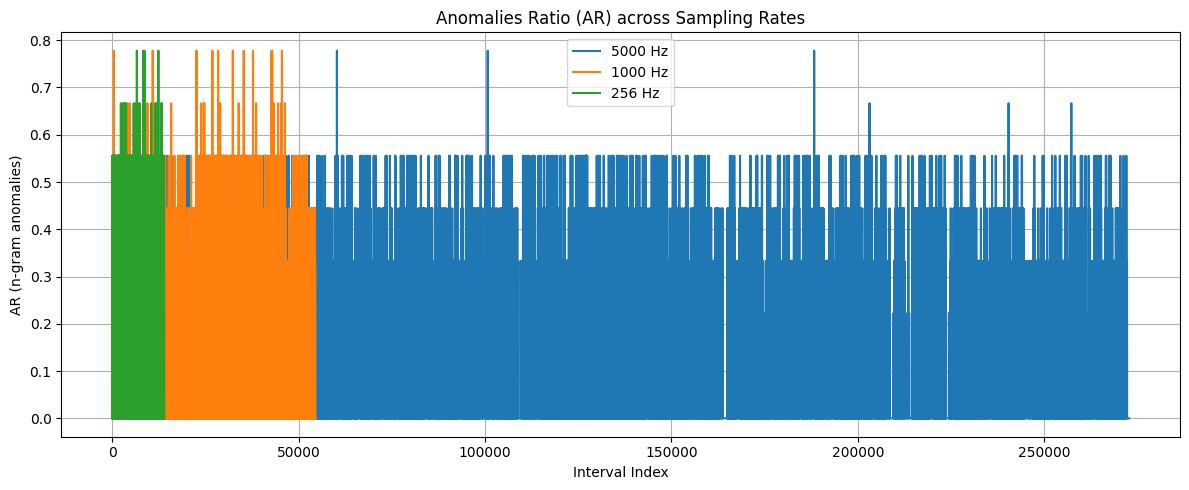

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from collections import Counter

def compute_ngram_ar(signal, pattern_length=11, bins=16, count_threshold=2):
    """
    Compute anomaly ratio (AR) using n-gram counts from quantized amplitude patterns.
    """
    # Quantize amplitude
    q_signal = np.digitize(signal, np.histogram(signal, bins=bins)[1][:-1])

    step = pattern_length
    ar_values = []

    for i in range(0, len(q_signal) - pattern_length + 1, step):
        segment = q_signal[i:i + pattern_length]
        ngrams = [tuple(segment[j:j+3]) for j in range(len(segment) - 2)]
        counts = Counter(ngrams)
        total = len(ngrams)
        uncommon = sum(1 for count in counts.values() if count < count_threshold)
        ar = uncommon / total if total > 0 else 0
        ar_values.append(ar)

    return np.array(ar_values)

def compare_sampling_effect_on_ar(eeg_channel, original_fs):
    """
    Downsamples the signal to 1000 Hz and 256 Hz and compares AR curves.
    """
    fs_targets = [5000, 1000, 256]
    plt.figure(figsize=(12, 5))

    for fs_new in fs_targets:
        if fs_new < original_fs:
            downsampled = resample(eeg_channel, int(len(eeg_channel) * fs_new / original_fs))
        else:
            downsampled = eeg_channel
        ar = compute_ngram_ar(downsampled, pattern_length=11)
        plt.plot(ar, label=f'{fs_new} Hz')

    plt.title("Anomalies Ratio (AR) across Sampling Rates")
    plt.xlabel("Interval Index")
    plt.ylabel("AR (n-gram anomalies)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# USAGE EXAMPLE:
# Assuming you already ran:
# eeg = np.array(s.data, dtype=float)
# fs  = float(s.sampling_frequency)
# signal = eeg[0, :int(200 * fs)]  # for example

compare_sampling_effect_on_ar(eeg[2], fs)


🔄 Loading EEG segments and preparing jobs...


Loading Segments:   0%|          | 0/3 [00:00<?, ?it/s]

📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_preictal_segment_0006.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_interictal_segment_0006.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
🔄 Downsampling: 3000000 → 153600 samples
🔄 Downsampling: 3000000 → 153600 samples


Loading Segments:  33%|███▎      | 1/3 [00:02<00:05,  2.69s/it]

📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_preictal_segment_0012.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_interictal_segment_0012.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
🔄 Downsampling: 3000000 → 153600 samples
🔄 Downsampling: 3000000 → 153600 samples


Loading Segments:  67%|██████▋   | 2/3 [00:05<00:02,  2.73s/it]

📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_preictal_segment_0018.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
📁 Loading: /content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1/Patient_1_interictal_segment_0018.mat
✅ Loaded shape: (15, 3000000), fs: 5000.0
🔄 Downsampling: 3000000 → 153600 samples
🔄 Downsampling: 3000000 → 153600 samples


Loading Segments: 100%|██████████| 3/3 [00:08<00:00,  2.80s/it]


⚙️ Running 1260 motif scoring jobs across PLs, segments, and channels...
📊 Expected jobs: 3 × 15 channels × 28 PLs = 1260


⏳ Scoring PLs:  32%|███▏      | 398/1260 [05:06<05:43,  2.51it/s]

🎯 Selected for plotting: 0006, RD_8, PL=23
   📊 Blocks: 60 pre, 60 inter


⏳ Scoring PLs:  33%|███▎      | 412/1260 [05:19<11:09,  1.27it/s]

   🔢 Pattern counts - Pre: [421, 188, 1509, 1166, 997]..., Inter: [6, 0, 0, 0, 6]...
   📈 RelDip: baseline=310.28, recent=1099.00, dip=-2.542
   ❌ Filtered: -2.542 < 0.01


⏳ Scoring PLs:  92%|█████████▏| 1156/1260 [14:41<01:02,  1.66it/s]

🎯 Selected for plotting: 0018, RD_5, PL=26
   📊 Blocks: 60 pre, 60 inter


⏳ Scoring PLs:  93%|█████████▎| 1171/1260 [14:53<00:50,  1.77it/s]

   🔢 Pattern counts - Pre: [0, 0, 0, 0, 0]..., Inter: [12, 0, 0, 0, 2]...
   📈 RelDip: baseline=11.07, recent=9.00, dip=0.187
   🎯 Score: 0.5×0.187 + 0.5×-0.455 = -0.134


⏳ Scoring PLs:  96%|█████████▌| 1205/1260 [15:19<00:24,  2.22it/s]

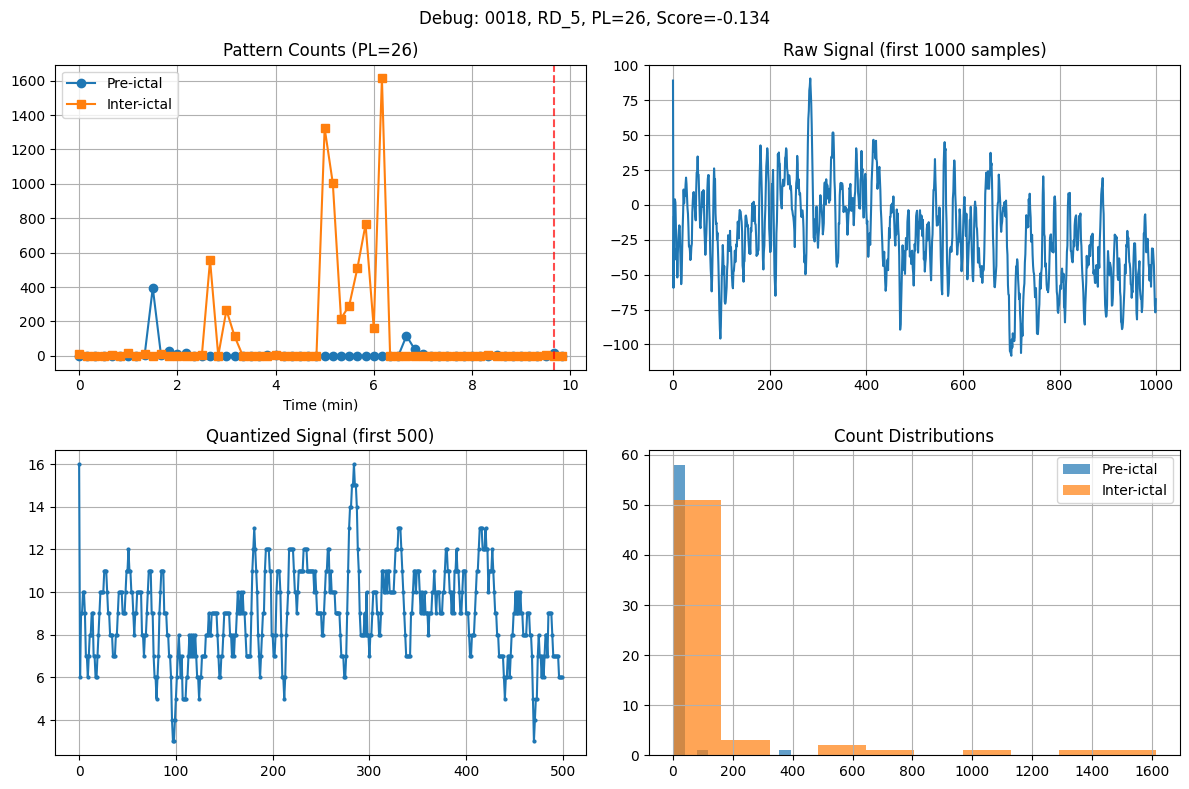

⏳ Scoring PLs: 100%|██████████| 1260/1260 [15:56<00:00,  1.32it/s]


✅ Completed in 965.08s — 535 rows passed REL_DIP filter.
📊 Processing Stats:
   • Total jobs processed: 1260
   • Jobs filtered out: 725
   • Success rate: 42.5%
   • Segments in results: ['0012' '0018']
   • Channels in results: ['LD_4' 'LD_5' 'LD_8' 'RD_1' 'RD_2' 'RD_3' 'RD_4' 'RD_5' 'RD_6' 'RD_7'
 'RD_8' 'LD_1' 'LD_3' 'LD_6' 'LD_7']
   • PL range in results: 3-30


,Segment,Channel,PL,avg_pre_occ,avg_int_occ,RelDip,Cohen_d,ΔMotifCount,Score
0,0012,LD_4,5,2297.400000,2361.166667,0.012558,-0.808578,-63.766667,-0.398010
1,0012,LD_4,6,2029.550000,2157.500000,0.025998,-0.834503,-127.950000,-0.404252
2,0012,LD_4,7,1675.350000,1867.400000,0.055070,-0.796399,-192.050000,-0.370665
3,0012,LD_4,8,1304.650000,1527.116667,0.113079,-0.721595,-222.466667,-0.304258
4,0012,LD_4,9,970.400000,1189.816667,0.205816,-0.647729,-219.416667,-0.220956
5,0012,LD_4,11,484.050000,638.533333,0.396577,-0.504199,-154.483333,-0.053811
6,0012,LD_4,10,696.766667,887.216667,0.305330,-0.570613,-190.450000,-0.132642
7,0012,LD_4,12,328.966667,446.766667,0.493221,-0.437004,-117.800000,0.028109
8,0012,LD_4,13,221.450000,307.383333,0.601740,-0.371588,-85.933333,0.115076
9,0012,LD_4,14,149.150000,210.683333,0.708691,-0.312671,-61.533333,0.198010


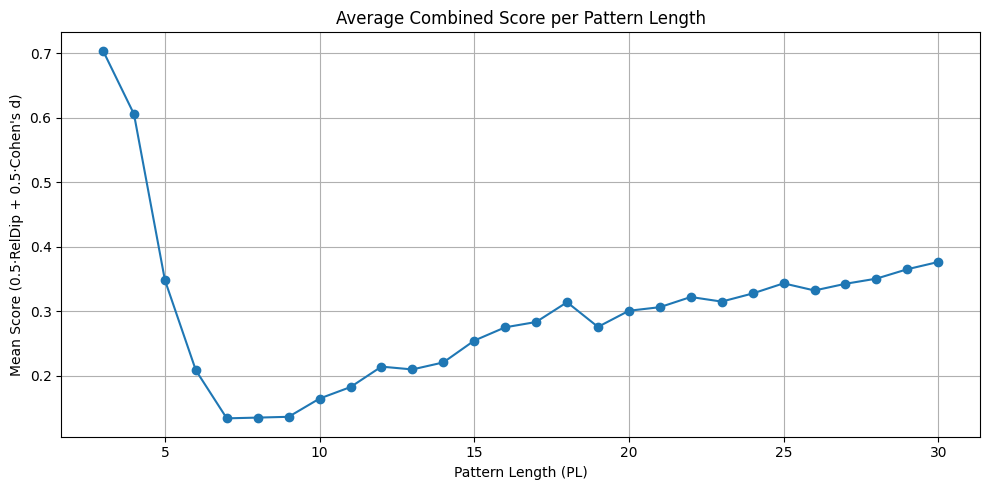

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import resample
from collections import Counter
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from time import time
from IPython.display import display
import random

# ----- CONFIG -----
WS_sec       = 10 * 60               # 10 min window
L_sec        = 10                    # 10 s blocks (you can adjust)
pattern_lengths = list(range(3, 31)) # Test p = 3…30
n_bins       = 16                    # quantization levels
target_fs    = 256                   # Hz after downsampling
CT           = 2                     # count-threshold for motif significance
REL_DIP_MIN  = 0.01                  # require ≥1% relative dip
alpha        = 0.5                   # weight between RelDip and Cohen's d
segments     = ['0006', '0012', '0018']
patient_id   = 'Patient_1'
base_path    = '/content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1'

# DEBUG ADDITIONS
debug_counter = 0
plot_samples = []

# ----- HELPERS -----
def load_segment(path):
    print(f"📁 Loading: {path}")  # ADDED
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    varname = next(k for k in mat.keys() if not k.startswith('__'))
    s = mat[varname]
    data = np.array(s.data, dtype=float)
    fs = float(s.sampling_frequency)
    print(f"✅ Loaded shape: {data.shape}, fs: {fs}")  # ADDED
    return data, fs, list(s.channels)

def downsample(eeg, original_fs, target_fs):
    new_len = int(eeg.shape[1] * target_fs / original_fs)
    print(f"🔄 Downsampling: {eeg.shape[1]} → {new_len} samples")  # ADDED
    return resample(eeg, new_len, axis=1)

def get_blocks(eeg, fs, ch_idx):
    ns = int(WS_sec * fs)
    blk_size = int(L_sec * fs)
    signal = eeg[ch_idx, :ns]
    blocks = [signal[i:i+blk_size]
            for i in range(0, ns, blk_size)][:WS_sec//L_sec]
    return blocks

def quantize(block, bins=n_bins):
    edges = np.histogram(block, bins=bins)[1]
    return np.digitize(block, edges[:-1])

def count_sig(block, p, CT=CT, bins=n_bins):
    """Quantize + count only motifs repeated ≥ CT times."""
    q = quantize(block, bins=bins)
    cnts = Counter(tuple(q[i:i+p]) for i in range(len(q)-p+1))
    return sum(c for c in cnts.values() if c >= CT)

def compute_cohens_d(x, y):
    m1, m2 = np.mean(x), np.mean(y)
    v1, v2 = np.var(x, ddof=1), np.var(y, ddof=1)
    s = np.sqrt((v1 + v2)/2) if (v1+v2)>0 else 1
    return (m1 - m2)/s

# ----- PARALLEL WORKER (UPDATED) -----
def process_job(seg_id, ch_idx, ch_label, p, pre_ds, int_ds):
    global debug_counter, plot_samples  # ADDED

    # DEBUG: Randomly sample some jobs for plotting
    if random.random() < 0.001 and len(plot_samples) < 3:  # ADDED
        should_plot = True
        plot_samples.append((seg_id, ch_label, p))
        print(f"🎯 Selected for plotting: {seg_id}, {ch_label}, PL={p}")
    else:
        should_plot = False

    # 1) split into blocks
    pre_blocks = get_blocks(pre_ds, target_fs, ch_idx)
    int_blocks = get_blocks(int_ds, target_fs, ch_idx)

    if should_plot:  # ADDED
        print(f"   📊 Blocks: {len(pre_blocks)} pre, {len(int_blocks)} inter")

    # 2) count significant motifs
    occ_pre = [count_sig(b, p) for b in pre_blocks]
    occ_int = [count_sig(b, p) for b in int_blocks]

    if should_plot:  # ADDED
        print(f"   🔢 Pattern counts - Pre: {occ_pre[:5]}..., Inter: {occ_int[:5]}...")

    # 3) compute relative dip in the last two blocks
    baseline = np.mean(occ_pre[:-2])
    pre2     = np.mean(occ_pre[-2:])
    rel_dip  = ((baseline - pre2) / baseline) if baseline>0 else 0

    if should_plot:  # ADDED
        print(f"   📈 RelDip: baseline={baseline:.2f}, recent={pre2:.2f}, dip={rel_dip:.3f}")

    # 4) filter out channels/patterns without a real dip
    if rel_dip < REL_DIP_MIN:
        if should_plot:  # ADDED
            print(f"   ❌ Filtered: {rel_dip:.3f} < {REL_DIP_MIN}")
        return None

    # 5) compute Cohen's d and delta
    d_score = compute_cohens_d(occ_pre, occ_int)
    delta   = np.mean(occ_pre) - np.mean(occ_int)

    # 6) combined score
    score = alpha * rel_dip + (1 - alpha) * d_score

    if should_plot:  # ADDED
        print(f"   🎯 Score: {alpha}×{rel_dip:.3f} + {1-alpha}×{d_score:.3f} = {score:.3f}")

        # PLOT this process
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # Plot pattern counts
        block_times = np.arange(len(occ_pre)) * L_sec / 60
        axes[0,0].plot(block_times, occ_pre, 'o-', label='Pre-ictal')
        axes[0,0].plot(block_times, occ_int, 's-', label='Inter-ictal')
        axes[0,0].axvline(x=block_times[-2], color='red', linestyle='--', alpha=0.7)
        axes[0,0].set_title(f'Pattern Counts (PL={p})')
        axes[0,0].set_xlabel('Time (min)')
        axes[0,0].legend()
        axes[0,0].grid(True)

        # Plot raw signal (first block)
        if pre_blocks:
            axes[0,1].plot(pre_blocks[0][:1000])
            axes[0,1].set_title('Raw Signal (first 1000 samples)')
            axes[0,1].grid(True)

        # Plot quantized signal (first block)
        if pre_blocks:
            q = quantize(pre_blocks[0])
            axes[1,0].plot(q[:500], 'o-', markersize=2)
            axes[1,0].set_title('Quantized Signal (first 500)')
            axes[1,0].grid(True)

        # Plot distributions
        axes[1,1].hist(occ_pre, alpha=0.7, label='Pre-ictal', bins=10)
        axes[1,1].hist(occ_int, alpha=0.7, label='Inter-ictal', bins=10)
        axes[1,1].set_title('Count Distributions')
        axes[1,1].legend()
        axes[1,1].grid(True)

        plt.suptitle(f'Debug: {seg_id}, {ch_label}, PL={p}, Score={score:.3f}')
        plt.tight_layout()
        plt.show()

    return {
        'Segment': seg_id,
        'Channel': ch_label,
        'PL': p,
        'avg_pre_occ': np.mean(occ_pre),
        'avg_int_occ': np.mean(occ_int),
        'RelDip': rel_dip,
        'Cohen_d': d_score,
        'ΔMotifCount': delta,
        'Score': score
    }

# ----- MAIN EXECUTION -----
start = time()
jobs = []
results = []

print("🔄 Loading EEG segments and preparing jobs...")
for seg_id in tqdm(segments, desc="Loading Segments"):
    pre_path = os.path.join(base_path, f'{patient_id}_preictal_segment_{seg_id}.mat')
    int_path = os.path.join(base_path, f'{patient_id}_interictal_segment_{seg_id}.mat')

    pre_eeg, fs, channels = load_segment(pre_path)
    int_eeg, _, _         = load_segment(int_path)

    pre_ds = downsample(pre_eeg , fs, target_fs)
    int_ds = downsample(int_eeg, fs, target_fs)

    for ch_idx, ch_label in enumerate(channels):
        for p in pattern_lengths:
            jobs.append((seg_id, ch_idx, ch_label, p, pre_ds, int_ds))

print(f"⚙️ Running {len(jobs)} motif scoring jobs across PLs, segments, and channels...")
print(f"📊 Expected jobs: {len(segments)} × 15 channels × {len(pattern_lengths)} PLs = {len(segments) * 15 * len(pattern_lengths)}")  # ADDED

# ADDED: Track filtering stats
total_processed = 0
total_filtered = 0

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_job, *job) for job in jobs]
    for f in tqdm(as_completed(futures), total=len(futures), desc="⏳ Scoring PLs"):
        out = f.result()
        total_processed += 1  # ADDED
        if out is not None:
            results.append(out)
        else:
            total_filtered += 1  # ADDED

# build DataFrame
df = pd.DataFrame(results)
print(f"\n✅ Completed in {time() - start:.2f}s — {len(df)} rows passed REL_DIP filter.")

# ADDED: Enhanced result analysis
print(f"📊 Processing Stats:")
print(f"   • Total jobs processed: {total_processed}")
print(f"   • Jobs filtered out: {total_filtered}")
print(f"   • Success rate: {len(df)/total_processed*100:.1f}%")
if len(df) > 0:
    print(f"   • Segments in results: {df['Segment'].unique()}")
    print(f"   • Channels in results: {df['Channel'].unique()}")
    print(f"   • PL range in results: {df['PL'].min()}-{df['PL'].max()}")

display(df.head(20))

# Plot summary: average combined Score per PL
if len(df) > 0:  # ADDED check
    avg_score = df.groupby("PL")["Score"].mean().reset_index()
    plt.figure(figsize=(10,5))
    plt.plot(avg_score["PL"], avg_score["Score"], marker='o')
    plt.title("Average Combined Score per Pattern Length")
    plt.xlabel("Pattern Length (PL)")
    plt.ylabel("Mean Score (0.5·RelDip + 0.5·Cohen's d)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:  # ADDED
    print("❌ No results to plot - all jobs were filtered out!")

In [ ]:
import numpy as np
import os
import pickle
from scipy.io import loadmat
from scipy.signal import resample
from tqdm import tqdm
import itertools

# ----------- CONFIGURATION -----------
WS_RANGE = [5, 10, 15]
L_RANGE = [10, 20,60]
PL_SETS = [[10, 8, 6, 4], [12, 10, 8, 6],[12, 13, 14, 15],[4, 5, 6, 7]]
OFFSET_RANGE = list(range(3, 5))

CT = 2
WEIGHT = 1
TARGET_FS = 256

segments = ['0006', '0012', '0018']
patient_id = 'Patient_1'
base_path = '/content/drive/MyDrive/BCI_Research_Week1/Datasets/Article1_IntracranialEEG/Patient_1'

# ----------- UTILITY FUNCTIONS -----------

def quantize_signal(signal, n_bins=16):
    hist, bin_edges = np.histogram(signal, bins=n_bins)
    return np.digitize(signal, bin_edges[:-1], right=True)

def calculate_anomaly_ratio(quantized_signal, pl_set, ct=2):
    total_samples = len(quantized_signal)
    sequenced = set()
    for pl in pl_set:
        patterns = {}
        for i in range(total_samples - pl + 1):
            pattern = tuple(quantized_signal[i:i+pl])
            patterns[pattern] = patterns.get(pattern, 0) + 1
        significant_patterns = {p for p, count in patterns.items() if count >= ct}
        for i in range(total_samples - pl + 1):
            pattern = tuple(quantized_signal[i:i+pl])
            if pattern in significant_patterns:
                sequenced.update(range(i, i + pl))
    unsequenced_count = total_samples - len(sequenced)
    return unsequenced_count / total_samples if total_samples > 0 else 0.0

def build_anomaly_matrix(eeg_window, fs, ws_sec, l_sec, pl_set, weight=1, ct=2):
    if weight > 1:
        eeg_window = eeg_window[:, ::weight]
        fs = fs // weight
    K = eeg_window.shape[0]
    interval_samples = int(l_sec * fs)
    n_intervals = ws_sec // l_sec
    anomaly_matrix = np.zeros((K, n_intervals))
    for ch in range(K):
        signal = eeg_window[ch, :]
        for i in range(n_intervals):
            start = i * interval_samples
            end = start + interval_samples
            if end > len(signal):
                break
            segment = signal[start:end]
            quantized = quantize_signal(segment)
            ar = calculate_anomaly_ratio(quantized, pl_set, ct=ct)
            anomaly_matrix[ch, i] = ar
    return anomaly_matrix

def load_segment(path):
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    varname = next(k for k in mat.keys() if not k.startswith('__'))
    s = mat[varname]
    data = np.array(s.data, dtype=float)
    fs = float(s.sampling_frequency)
    return data, fs, list(s.channels)

def downsample(eeg, original_fs, target_fs):
    if original_fs == target_fs:
        return eeg
    new_len = int(eeg.shape[1] * target_fs / original_fs)
    return resample(eeg, new_len, axis=1)

def extract_window(eeg, fs, window_size_sec, offset_sec=0):
    total_samples = eeg.shape[1]
    end = total_samples - int(offset_sec * fs)
    start = end - int(window_size_sec * fs)
    if start < 0:
        return None
    return eeg[:, start:end]

# ----------- MAIN EXTRACTION -----------

ar_feature_data = []
grid_combos = list(itertools.product(WS_RANGE, L_RANGE, PL_SETS, OFFSET_RANGE))

for ws, l, pl_set, offset in tqdm(grid_combos, desc="🔍 Grid Search", leave=False):
    for seg_id in tqdm(segments, desc=f"Segment {ws}-{l}-{offset}", leave=False):
        try:
            pre_path = os.path.join(base_path, f'{patient_id}_preictal_segment_{seg_id}.mat')
            int_path = os.path.join(base_path, f'{patient_id}_interictal_segment_{seg_id}.mat')
            pre_eeg, fs, _ = load_segment(pre_path)
            int_eeg, _, _ = load_segment(int_path)

            pre_eeg = downsample(pre_eeg, fs, TARGET_FS)
            int_eeg = downsample(int_eeg, fs, TARGET_FS)
            fs = TARGET_FS
            ws_sec = ws * 60

            # Preictal
            pre_win = extract_window(pre_eeg, fs, window_size_sec=ws_sec, offset_sec=offset * 60)
            if pre_win is not None:
                pre_ar = build_anomaly_matrix(pre_win, fs, ws_sec, l, pl_set, weight=WEIGHT)
                ar_feature_data.append({
                    'matrix': pre_ar,
                    'label': 1,
                    'segment': seg_id,
                    'params': {'ws': ws, 'l': l, 'pl_set': pl_set, 'offset': offset}
                })

            # Interictal
            int_win = extract_window(int_eeg, fs, window_size_sec=ws_sec, offset_sec=0)
            if int_win is not None:
                int_ar = build_anomaly_matrix(int_win, fs, ws_sec, l, pl_set, weight=WEIGHT)
                ar_feature_data.append({
                    'matrix': int_ar,
                    'label': 0,
                    'segment': seg_id,
                    'params': {'ws': ws, 'l': l, 'pl_set': pl_set, 'offset': offset}
                })

        except Exception as e:
            print(f"⚠️ Error in segment {seg_id} with (ws={ws}, l={l}, pl_set={pl_set}, offset={offset}): {e}")

# ----------- SAVE RESULTS -----------

with open("ar_feature_data.pkl", "wb") as f:
    pickle.dump(ar_feature_data, f)

print("✅ AR matrix extraction complete.")
print(f"💾 Saved {len(ar_feature_data)} matrices to ar_feature_data.pkl")


Segment 5-10-3:  33%|███▎      | 1/3 [00:38<01:16, 38.22s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-8-98801712.py", line 120, in <cell line: 0>
    int_ar = build_anomaly_matrix(int_win, fs, ws_sec, l, pl_set, weight=WEIGHT)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-8-98801712.py", line 62, in build_anomaly_matrix
    ar = calculate_anomaly_ratio(quantized, pl_set, ct=ct)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-8-98801712.py", line None, in calculate_anomaly_ratio
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^

In [ ]:


# ----- HELPER FUNCTIONS -----
def load_segment(path):
    """Load EEG segment from .mat file"""
    mat = loadmat(path, struct_as_record=False, squeeze_me=True)
    varname = next(k for k in mat.keys() if not k.startswith('__'))
    s = mat[varname]
    data = np.array(s.data, dtype=float)
    fs = float(s.sampling_frequency)
    return data, fs, list(s.channels)

def downsample(eeg, original_fs, target_fs):
    """Downsample EEG to target frequency"""
    if original_fs == target_fs:
        return eeg
    new_len = int(eeg.shape[1] * target_fs / original_fs)
    return resample(eeg, new_len, axis=1)

def reduce_by_weight(signal, weight):
    """Reduce data resolution by weight factor"""
    if weight == 1:
        return signal
    return signal[::weight]

def extract_window(eeg, fs, window_start_sec, window_size_sec, offset_sec=0):
    """Extract a window from EEG data with offset from end"""
    # Calculate sample indices
    total_samples = eeg.shape[1]
    window_end_sample = total_samples - int(offset_sec * fs)
    window_start_sample = window_end_sample - int(window_size_sec * fs)

    if window_start_sample < 0:
        return None

    return eeg[:, window_start_sample:window_end_sample]

def calculate_anomaly_ratio(signal, pattern_lengths, ct=CT, scheme='overlapping'):
    """
    Calculate anomaly ratio as per paper:
    AR = C(unsequenced samples) / C(all samples)
    """
    total_samples = len(signal)
    sequenced_samples = set()

    # For each pattern length
    for pl in pattern_lengths:
        # Count patterns with overlapping scheme
        patterns = {}
        for i in range(len(signal) - pl + 1):
            pattern = tuple(signal[i:i+pl])
            patterns[pattern] = patterns.get(pattern, 0) + 1

        # Find significant patterns (count >= CT)
        significant_patterns = {p: c for p, c in patterns.items() if c >= ct}

        # Mark samples that are part of significant patterns
        for i in range(len(signal) - pl + 1):
            pattern = tuple(signal[i:i+pl])
            if pattern in significant_patterns:
                for j in range(i, i + pl):
                    sequenced_samples.add(j)

    # Calculate anomaly ratio
    unsequenced_count = total_samples - len(sequenced_samples)
    anomaly_ratio = unsequenced_count / total_samples if total_samples > 0 else 0

    return anomaly_ratio

def quantize_signal(signal, n_bins=16):
    """Quantize signal into n_bins levels"""
    # Use histogram to get bin edges
    _, edges = np.histogram(signal, bins=n_bins)
    # Digitize signal
    return np.digitize(signal, edges[:-1])

def extract_features_for_window(eeg_window, fs, ws_sec, l_sec, pl_set, weight=1):
    """
    Extract anomaly ratios for all channels and intervals in a window
    Returns: Feature matrix of shape (n_channels, n_intervals)
    """
    n_channels = eeg_window.shape[0]
    n_intervals = ws_sec // l_sec
    interval_samples = int(l_sec * fs)

    features = []

    for ch_idx in range(n_channels):
        channel_features = []
        signal = eeg_window[ch_idx, :]

        # Reduce by weight if needed
        if weight > 1:
            signal = reduce_by_weight(signal, weight)
            interval_samples = interval_samples // weight

        # Extract features for each interval
        for interval_idx in range(n_intervals):
            start_idx = interval_idx * interval_samples
            end_idx = start_idx + interval_samples

            if end_idx > len(signal):
                break

            interval_signal = signal[start_idx:end_idx]

            # Quantize the signal
            quantized = quantize_signal(interval_signal)

            # Calculate anomaly ratio
            ar = calculate_anomaly_ratio(quantized, pl_set)
            channel_features.append(ar)

        features.append(channel_features)

    return np.array(features)

def create_dataset(segments_dict, ws_sec, l_sec, pl_set, offset_sec, weight=1):
    """
    Create dataset with features and labels for all segments
    Returns: X (features), y (labels), channel_names
    """
    X_all = []
    y_all = []
    channel_names = None

    for seg_id, (pre_data, int_data, fs, channels) in segments_dict.items():
        if channel_names is None:
            channel_names = channels

        # Extract pre-ictal window (label = 1)
        pre_window = extract_window(pre_data, fs, 0, ws_sec * 60, offset_sec * 60)
        if pre_window is not None:
            pre_features = extract_features_for_window(pre_window, fs, ws_sec * 60, l_sec, pl_set, weight)
            # Flatten features for each channel
            for ch_features in pre_features:
                if len(ch_features) == (ws_sec * 60) // l_sec:  # Check if we got all intervals
                    X_all.append(ch_features)
                    y_all.append(1)  # Pre-ictal

        # Extract random inter-ictal windows (label = 0)
        # Take multiple non-overlapping windows from inter-ictal
        int_duration_sec = int_data.shape[1] / fs
        n_windows = int(int_duration_sec // (ws_sec * 60)) - 1

        for win_idx in range(min(n_windows, 3)):  # Limit to 3 windows per segment
            start_sec = win_idx * ws_sec * 60
            int_window = int_data[:, int(start_sec * fs):int((start_sec + ws_sec * 60) * fs)]

            if int_window.shape[1] == int(ws_sec * 60 * fs):
                int_features = extract_features_for_window(int_window, fs, ws_sec * 60, l_sec, pl_set, weight)
                for ch_features in int_features:
                    if len(ch_features) == (ws_sec * 60) // l_sec:
                        X_all.append(ch_features)
                        y_all.append(0)  # Inter-ictal

    return np.array(X_all), np.array(y_all), channel_names

def evaluate_parameters(X, y, test_size=0.2, random_state=42):
    """
    Evaluate parameters using Random Forest as per paper
    Returns: accuracy, sensitivity, FAR
    """
    if len(X) == 0 or len(y) == 0:
        return 0, 0, 1  # Worst case scores

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rf.fit(X_train, y_train)

    # Predict
    y_pred = rf.predict(X_test)

    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    far = fp / (tn + fp) if (tn + fp) > 0 else 1

    return accuracy, sensitivity, far

# ----- MAIN GRID SEARCH -----
def run_grid_search():
    """Run exhaustive grid search to find optimal parameters"""

    print("🔄 Loading EEG segments...")
    segments_data = {}

    for seg_id in segments:
        pre_path = os.path.join(base_path, f'{patient_id}_preictal_segment_{seg_id}.mat')
        int_path = os.path.join(base_path, f'{patient_id}_interictal_segment_{seg_id}.mat')

        pre_eeg, fs, channels = load_segment(pre_path)
        int_eeg, _, _ = load_segment(int_path)

        # Downsample if needed
        pre_ds = downsample(pre_eeg, fs, TARGET_FS)
        int_ds = downsample(int_eeg, fs, TARGET_FS)

        segments_data[seg_id] = (pre_ds, int_ds, TARGET_FS, channels)

    print(f"✅ Loaded {len(segments_data)} segments")
    print(f"📊 Channels: {len(channels)}")

    # Grid search
    results = []
    total_combinations = len(WS_RANGE) * len(L_RANGE) * len(PL_SETS) * len(OFFSET_RANGE)

    print(f"\n🔍 Starting grid search with {total_combinations} combinations...")

    with tqdm(total=total_combinations) as pbar:
        for ws, l, pl_set, offset in itertools.product(WS_RANGE, L_RANGE, PL_SETS, OFFSET_RANGE):
            try:
                # Create dataset with current parameters
                X, y, _ = create_dataset(segments_data, ws, l, pl_set, offset, WEIGHT)

                if len(X) > 0:
                    # Evaluate parameters
                    accuracy, sensitivity, far = evaluate_parameters(X, y)

                    results.append({
                        'WS': ws,
                        'L': l,
                        'PL': pl_set,
                        'Offset': offset,
                        'Accuracy': accuracy,
                        'Sensitivity': sensitivity,
                        'FAR': far,
                        'n_samples': len(X)
                    })
            except Exception as e:
                print(f"Error with params WS={ws}, L={l}, PL={pl_set}, Offset={offset}: {e}")

            pbar.update(1)

    # Convert to DataFrame and sort by accuracy
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)

    return results_df

# ----- VISUALIZATION -----
def plot_grid_search_results(results_df):
    """Visualize grid search results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Top 10 results
    top_10 = results_df.head(10)
    ax = axes[0, 0]
    x = range(len(top_10))
    ax.bar(x, top_10['Accuracy'], alpha=0.7, label='Accuracy')
    ax.bar(x, top_10['Sensitivity'], alpha=0.7, label='Sensitivity')
    ax.bar(x, top_10['FAR'], alpha=0.7, label='FAR')
    ax.set_xlabel('Parameter Set')
    ax.set_ylabel('Score')
    ax.set_title('Top 10 Parameter Combinations')
    ax.legend()
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['WS']}m" for _, row in top_10.iterrows()], rotation=45)

    # Accuracy vs Window Size
    ax = axes[0, 1]
    ws_grouped = results_df.groupby('WS')['Accuracy'].agg(['mean', 'std'])
    ax.errorbar(ws_grouped.index, ws_grouped['mean'], yerr=ws_grouped['std'],
                marker='o', capsize=5)
    ax.set_xlabel('Window Size (minutes)')
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Accuracy vs Window Size')
    ax.grid(True, alpha=0.3)

    # Accuracy vs Interval Length
    ax = axes[1, 0]
    l_grouped = results_df.groupby('L')['Accuracy'].agg(['mean', 'std'])
    ax.errorbar(l_grouped.index, l_grouped['mean'], yerr=l_grouped['std'],
                marker='s', capsize=5, color='green')
    ax.set_xlabel('Interval Length (seconds)')
    ax.set_ylabel('Mean Accuracy')
    ax.set_title('Accuracy vs Interval Length')
    ax.grid(True, alpha=0.3)

    # Heatmap of WS vs L
    ax = axes[1, 1]
    pivot = results_df.pivot_table(values='Accuracy', index='L', columns='WS', aggfunc='mean')
    im = ax.imshow(pivot, cmap='viridis', aspect='auto')
    ax.set_xlabel('Window Size (minutes)')
    ax.set_ylabel('Interval Length (seconds)')
    ax.set_title('Mean Accuracy Heatmap')
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

# ----- RUN THE GRID SEARCH -----
if __name__ == "__main__":
    print("🚀 Starting N-gram Grid Search (Paper Implementation)")
    print("=" * 60)

    # Run grid search
    results_df = run_grid_search()

    # Display results
    print("\n📊 Top 10 Parameter Combinations:")
    print(results_df.head(10))

    # Save results
    results_df.to_csv('ngram_grid_search_results.csv', index=False)
    print("\n💾 Results saved to 'ngram_grid_search_results.csv'")

    # Plot results
    plot_grid_search_results(results_df)

    # Show best parameters
    best_params = results_df.iloc[0]
    print("\n🏆 Best Parameters:")
    print(f"   Window Size: {best_params['WS']} minutes")
    print(f"   Interval Length: {best_params['L']} seconds")
    print(f"   Pattern Lengths: {best_params['PL']}")
    print(f"   Offset: {best_params['Offset']} minutes")
    print(f"   Accuracy: {best_params['Accuracy']:.2%}")
    print(f"   Sensitivity: {best_params['Sensitivity']:.2%}")
    print(f"   FAR: {best_params['FAR']:.2%}")

🚀 Starting N-gram Grid Search (Paper Implementation)
🔄 Loading EEG segments...
✅ Loaded 3 segments
📊 Channels: 15

🔍 Starting grid search with 6000 combinations...


  1%|          | 32/6000 [22:32<70:05:13, 42.28s/it]


KeyboardInterrupt: 